# AUEB M.Sc. in Data Science (part-time)

**Course**: Practical Data Science

**Semester**: Fall 2018

**2nd homework**: Predicting Energy Consumption

**Author**: Spiros Politis

---

# Homework description

In this homework you will work on the entire machine learning pipeline, end-to-end.

To do so, we will use the __[Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)__ from UCI. It is a standard regression problem.

The objective of the homework is not merely to make predictions and report some scores, but rather to be exposed in Machine Learning as a process.

## Homework questions

### Feature Engineering

Using your imagination and intuition, add some more features to your data (at least 2).

To do so, think: "What factors - independent variables affect energy consumption ?". "How can I quantify those as new variables and columns in my DataFrame? " Hint: In time series - data such as this for instance, __[DatetimeProperties](http://pandas.pydata.org/pandas-docs/version/0.15.2/api.html#datetimelike-properties)__ is your best (but not only) friend.

**Bonus Question** Does the data support your intuition ? Use your data exploration skills (see 1st assiegnment) to see whether or not your intuition is supported by the data at hand.

### Train 3 different models on the data

You are expected to train the following type of models (using only scikit-learn).

- A simple linear regression - based model
- A SVM-based regression model (see __[SVR](https://scikit-learn.org/stable/modules/svm.html#svm-regression)__)
- A decision trees (random forest) - based model.

At this point do not try any parameter tuning - you should use just the default ones.

You are expected however to:

- identify and do any preprocessing necessary for each model (using Pandas).
- identify and discuss the error metric you will use (the same for all models).

By the end of the process you should have the following 3 objects (Estimators) fitted and ready to use: [<mark>lin_model</mark>, <mark>svr_model</mark>, <mark>rf_model</mark>]

### Model Evaluation & Selection

Design and implement a cross validation strategy for your data. Run it (the same strategy) for all 3 models and report scores.

### Parameter Tuning

Select the "best" model reported from the previous question. For that model develop and implement a grid search strategy, using __[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)__.

Things can get out of hand at this stage, so you should focus on tuning 2-3 parameters (setting the parameter grid) and a reasonable search space. The model should take a max a few minutes to train in a commodity machine.

### Spoiler alert

Code from this homework (escpeciallsy questions 3 and 4) will be reused in your next homework, thus treat your code approprietly.

### Submission Instructions

You must submit your homework as a Jupyter notebook that will contain the full code and documentation of how you solved the questions. The Jupyter notebook must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results. Anything not written in that Jupyter notebook, will not be taken into consideration.

### Honor Code

You understand that this is an individual homework, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the homework and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.

You should be able to justify **why** you wrote that particular line of code.

---

# Homework implementation

## Required libraries, configuration and global functions

In [1]:
# Basic imports
import sys
import os
from datetime import datetime, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Matplotlib config
%matplotlib inline

# Seaborn config
sns.set(style = "darkgrid")

# Set a random seed so that possible random operations 
# performed by us can be replicated by others.
np.random.seed(19730618)

In [2]:
# Global variables controlling key aspects of the train-test process

# Whether to drop detailed temp and humidity observations, 
# after having created statistics for them
DROP_DETAILED_T_OBSERVATIONS = True
DROP_DETAILED_RH_OBSERVATIONS = True

# Group by day_of_month, day_of_week and hour
GROUP = True

# Use MinMax or Standard scaler
STANDARD_SCALE = False

# Whether to log-transform the target.
# Setting the var to None because we need to investigate first.
LOG_TRANSFORM_Y = None

# K-Fold cross validation folds
K_FOLDS = 5

In [3]:
# Global variables for plot styling
plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

In [4]:
"""
Check for nulls in a DataFrame

:param df: the source DataFrame
:returns: None, if no nulls found, otherwise the list of columns of the DataFrame that contain null values
"""
def check_nulls(df):
    if df.isnull().any().sum() == 0:
        return None
    else:
        return df.columns[df.isna().any()].tolist()


"""
Data train-test split helper

:param df: the source DataFrame
:param features: a list of features to include in the X_train, X_test sets
:param num_splits: the number of splits of the TimeSeriesSplit
:param split_select: integer, indicates the TimeSeriesSplit slice to select
:returns:
- A TimeSeriesSplit object, if param split_select is None
- A (X_train, X_test, y_train, y_test) tupple if split_select is not None
"""
'''
    This function returns either of:
    
    * A TimeSeriesSplit object, if param **split_select** is None
    * A (X_train, X_test, y_train, y_test) tupple if **split_select** is not None.
'''
def train_test_split(df, features, target, test_size = 0.2, shuffle = True):
    from sklearn.model_selection import train_test_split
    
    # Select feature data
    X = df[features]
    
    # Select the response variable
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 19730618)
    
    return X_train, X_test, y_train, y_test


"""
Helper function for plotting a Pearson correlation matrix

:param df: the source DataFrame
:param features_list: the features to include
:param figsize: the plot figure size
"""
def plot_correlation_matrix(df, features_list = None, figsize = (14, 14)):
    fig, ax = plt.subplots(ncols = 1, figsize = figsize)
    color_map = sns.cubehelix_palette(light = 1, as_cmap = True)
    
    plot_main_title_font = {
        "family": "sans serif",
        "color":  "black",
        "weight": "bold",
        "size": 18,
    }
    
    plot_axis_title_font = {
        "family": "sans serif",
        "color":  "black",
        "weight": "bold",
        "size": 14,
    }
    
    # Set graph title
    ax.set_title(label = "Pearson correlation of features", fontdict = plot_main_title_font, pad = 20)
    
    # Set axis labels
    ax.set_xlabel(xlabel = "Feature", fontdict = plot_axis_title_font, labelpad = 20)
    ax.set_ylabel(ylabel = "Feature", fontdict = plot_axis_title_font, labelpad = 20)
    
    # Get the correlation metrics
    if features_list == None:
        pearson_corr = df.corr()
    else:
        pearson_corr = df[features_list].corr()
    
    # Plot the correlation heatmap
    sns.heatmap(data = pearson_corr, xticklabels = pearson_corr.columns.values, yticklabels = pearson_corr.columns.values, cmap = color_map, linewidths = 0.1, mask = None, ax = ax)


"""
Printing linear model functions helper

:param coefficients: linear model coefficients list
:param names: coefficient names list
:param sort: wether to sort coefficients or not
:returns: string representing the linear model function
"""
def get_linear_model_function(coefficients, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefficients))]
    
    coefficients_list = zip(coefficients, names)
    
    if sort:
        coefficients_list = sorted(coefficients_list,  key = lambda x: -np.abs(x[0]))
    
    return " + ".join("%s * %s" % (round(coefficient, 3), name) for coefficient, name in coefficients_list)

 
# Do not output docstrings
pass;

## Acquiring data

Data has been downloaded directly from __[Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)__ from UCI. Some important meta information for the data set are presented below.

**General information**

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis ([rp5.ru](https://rp5.ru/)), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

**Features description**

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, [rp5.ru](https://rp5.ru/). Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data. 

### Loading of the CSV file

In [5]:
energy_csv = "energydata_complete.csv"

energy_df = pd.read_csv(os.getcwd() + "/data/" + energy_csv, delimiter = ",", header = 0)

### Inspecting, cleaning and transforming the dataset

Let' take a look at the dataset:

In [6]:
energy_df.head(5)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


...and its columns:

In [7]:
print(energy_df.columns)

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')


Let's sanitize our column names a bit:

In [8]:
# Replace any spaces with underscores
energy_df.columns = energy_df.columns.str.replace(" ", "_")

# Make sure we strip any invisible white spaces
energy_df.columns = energy_df.columns.str.strip()

# Set all columns names to lower case
energy_df.columns = energy_df.columns.str.lower()

We should also check whether features loaded into the data frame from the CSV file have the appropriate data types:

In [9]:
for column in energy_df.columns:
    print("Column name: ", column, " / Data type: ", type(energy_df[column][0]))

Column name:  date  / Data type:  <class 'str'>
Column name:  appliances  / Data type:  <class 'numpy.int64'>
Column name:  lights  / Data type:  <class 'numpy.int64'>
Column name:  t1  / Data type:  <class 'numpy.float64'>
Column name:  rh_1  / Data type:  <class 'numpy.float64'>
Column name:  t2  / Data type:  <class 'numpy.float64'>
Column name:  rh_2  / Data type:  <class 'numpy.float64'>
Column name:  t3  / Data type:  <class 'numpy.float64'>
Column name:  rh_3  / Data type:  <class 'numpy.float64'>
Column name:  t4  / Data type:  <class 'numpy.float64'>
Column name:  rh_4  / Data type:  <class 'numpy.float64'>
Column name:  t5  / Data type:  <class 'numpy.float64'>
Column name:  rh_5  / Data type:  <class 'numpy.float64'>
Column name:  t6  / Data type:  <class 'numpy.float64'>
Column name:  rh_6  / Data type:  <class 'numpy.float64'>
Column name:  t7  / Data type:  <class 'numpy.float64'>
Column name:  rh_7  / Data type:  <class 'numpy.float64'>
Column name:  t8  / Data type:  <c

Looks like we should convert column **date** to DateTime (it was parsed as string). Also, transform **appliances** and **lights** to *numpy.float64* so as to be consistent with the types of the rest of the features:

In [10]:
# Use column "date" as the dataframe index.
# Including the date format dramatically increases performance.
energy_df.index = pd.DatetimeIndex(pd.to_datetime(energy_df["date"], format = "%Y-%m-%d %H:%M:%S", utc = True))

# Transform 'appliances' and 'appliances' to numpy.float64
energy_df["appliances"] = energy_df["appliances"].astype(np.float64)
energy_df["lights"] = energy_df["lights"].astype(np.float64)

# Drop unused column "date"
energy_df = energy_df.drop("date", axis = 1)

Let us proceed with examining if any columns contain null values:

In [11]:
nulls = check_nulls(energy_df)

if nulls == None:
    print("No nulls found")
else:
    print("Nulls contained in columns ", nulls)

No nulls found


## Feature Engineering

### Random features

First things first, we have no use for random variables **rv1** and **rv2** which are only introducing random noise in the data, therefore we should drop them:

In [12]:
energy_df = energy_df.drop(["rv1", "rv2"], axis = 1)

### Time-related features

Perhaps the most influencing parameter in household energy consumption patterns is human activity in the household. Intuitively, we believe that consumption should flunctuate accross hours of the day. For instance, we should expect to see that consumption is lowest between midnight and early in the morning, while the occupants of the household sleep.

We should investigate this assumption:

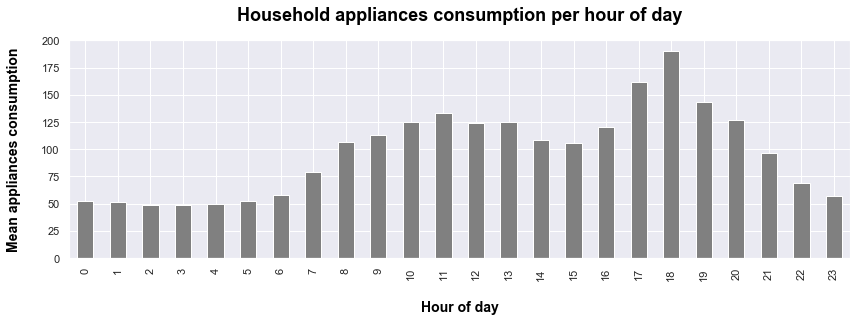

In [13]:
fig, ax = plt.subplots(figsize = (14, 4))

# Group by hour, appliances
energy_df_gb_a = energy_df.groupby([energy_df.index.hour])["appliances"]
energy_df_gb_a.mean().plot(kind = "bar", color = "grey")

# Set graph title
ax.set_title(label = "Household appliances consumption per hour of day", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Hour of day", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Mean appliances consumption", fontdict = plot_axis_title_font, labelpad = 20)

pass;

The substantial flunctuation in appliance consumption per hour indicates that we should include this feature in our data set.

In [14]:
energy_df["hour"] = energy_df.index.hour

Let's try to see if another pattern emerges in appliance consumption accross days of the month: 

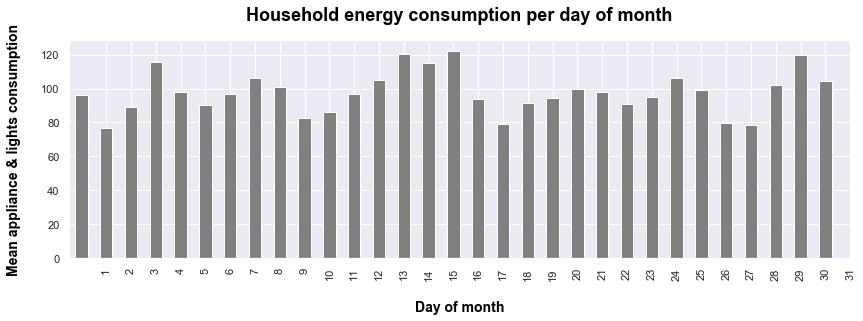

In [15]:
from matplotlib import dates

fig, ax = plt.subplots(figsize = (14, 4))

# Group by week day, appliances
energy_df_gb_md_a = energy_df.groupby(energy_df.index.day)["appliances"]
energy_df_gb_md_a_m = energy_df_gb_md_a.mean()
energy_df_gb_md_a_m.plot(kind = "bar", color = "grey")

# Set graph title
ax.set_title(label = "Household energy consumption per day of month", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Day of month", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Mean appliance & lights consumption", fontdict = plot_axis_title_font, labelpad = 20)

# Set x-axis ticks and corresponding labels to be the index of our series object
ax.set_xticks(ticks = energy_df_gb_md_a_m.index);
ax.set_xticklabels(labels = energy_df_gb_md_a_m.index)

pass;

We can see that there seems to be flunctuation in appliances copnsumption accross days of the month. We shall include the **day_of_month** feature in our dataset to cater for daily flunctuations in consumption:

In [16]:
energy_df["day_of_month"] = energy_df.index.day

We could also consider including the day of week feature in the data set on the hunch that appliance consumption might vary during weekends with respect to working day consumption. Let's investigate:

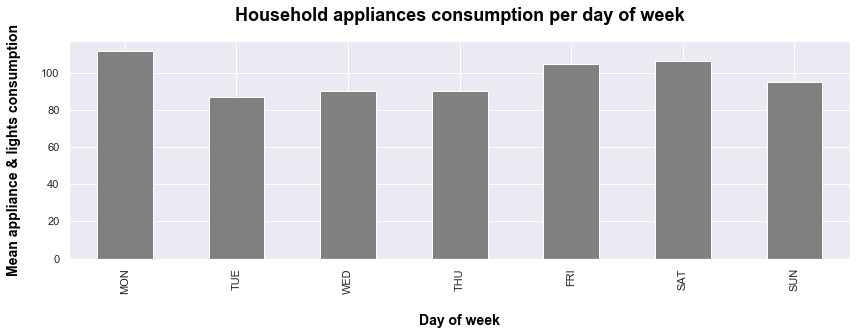

In [17]:
from matplotlib import dates

day_names = {
    0: 'MON',
    1: 'TUE', 
    2: 'WED', 
    3: 'THU',
    4: 'FRI', 
    5: 'SAT', 
    6: 'SUN'
}

fig, ax = plt.subplots(figsize = (14, 4))

# Group by week day, appliances
energy_df_gb_wd_a = energy_df.groupby(energy_df.index.weekday)["appliances"]
energy_df_gb_wd_a_m = energy_df_gb_wd_a.mean()
energy_df_gb_wd_a_m.plot(kind = "bar", color = "grey")

# Set graph title
ax.set_title(label = "Household appliances consumption per day of week", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Day of week", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Mean appliance & lights consumption", fontdict = plot_axis_title_font, labelpad = 20)

# Set x-axis ticks and corresponding labels to be the index of our series object
ax.set_xticks(ticks = energy_df_gb_wd_a_m.index);
ax.set_xticklabels(labels = [day_names[x] for x in energy_df_gb_wd_a_m.index])

pass;

The graph shows some variance of appliance consumption between days of the week. We will include the **day_of_week** feature in our analysis:

In [18]:
energy_df["day_of_week"] = energy_df.index.weekday

### Temperature and humidity features

Intuitively, we can tell that it is overkill to keep all detailed measurements for temperature and humidity for every room in the house. We assume that a meaningful measure of temperature and humidity would be the mean of such readings. We need to verify our intuition though. A Pearson correlation plot could help us validate our assumptions. We would expect individual measurements of temperature and humidity to have a high correlation coefficient, hence not adding any new information to our model while emphasizing the problem of colinearity.

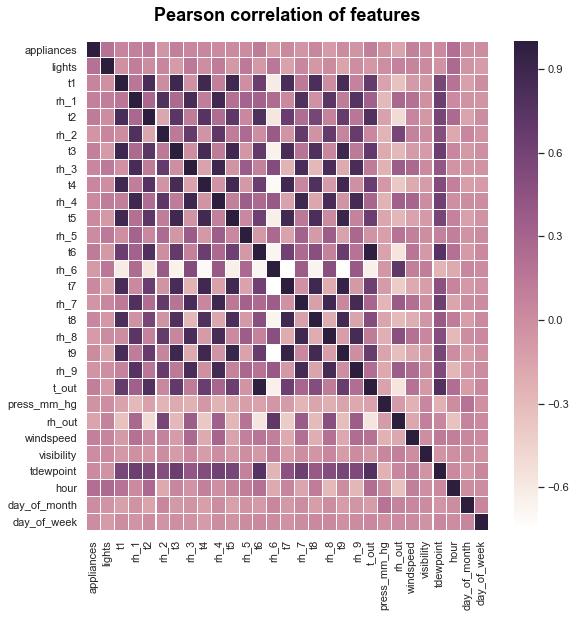

In [19]:
plot_correlation_matrix(df = energy_df, figsize = (9, 9));

We can indeed tell that indoor temperature (within their group) and humidity measurements (within their group) have a high, positive correlation. Note, also, how our intuition is enforced by observing variable **rh_5**, which is shown to be less correlated with others and this makes sense, since this feature is the measurement of humidity in the bathroom where we would expect this measurement to be higher than the rest of the building.

We shall therefore create two new columns, **mean_t_in** and **mean_rh_in** that summarize the metrics mentioned above.

However, we will immediatelly discard measurement **t6**, **rh_6** in favor of **t_out**, **rh_out** respectivelly, since these two are measurements of outside temperature and have a very high positive correlation.

Normally, we would do away with detailed observations, however we shall refrain from doing so immediatelly, not before assessing all features in our data set as we will do in a later section. To achieve this, we will employ the global variables **DROP_DETAILED_T_OBSERVATIONS** and **DROP_DETAILED_RH_OBSERVATIONS**.

In [20]:
# Indoor temperature columns
t_in_cols = ["t1", "t2", "t3", "t4", "t5", "t7", "t8", "t9"]
# Indoor humidity columns
hr_in_cols = ["rh_1", "rh_2", "rh_3", "rh_4", "rh_5", "rh_7", "rh_8", "rh_9"]

# Append new colums
energy_df["t_in_mean"] = pd.DataFrame.mean(energy_df[t_in_cols], axis = 1)
energy_df["rh_in_mean"] = pd.DataFrame.mean(energy_df[hr_in_cols], axis = 1)

# Discard columns
energy_df = energy_df.drop("t6", axis = 1)
energy_df = energy_df.drop("rh_6", axis = 1)

if DROP_DETAILED_T_OBSERVATIONS:
    energy_df = energy_df.drop(t_in_cols, axis = 1)
    
    print("Dropped detailed observations about temperature")
else:
    print("Retaining detailed observations about temperature")
    
if DROP_DETAILED_RH_OBSERVATIONS:
    energy_df = energy_df.drop(hr_in_cols, axis = 1)
    
    print("Dropped detailed observations about humidity")
else:
    print("Retaining detailed observations about humidity")

Dropped detailed observations about temperature
Dropped detailed observations about humidity


Another useful feature may prove to be the **difference** between indoor-outdoor temperature and humidity, the rationale being that appliances such as heaters, air-conditioners and dehumidifiers, who are all heavy energy consumers, would be in operation when the difference between the indoor-outdoor measurements is significant:

In [21]:
energy_df["t_in_out_diff"] = energy_df["t_in_mean"] - energy_df["t_out"]
energy_df["rh_in_out_diff"] = energy_df["rh_in_mean"] - energy_df["rh_out"]

**Perceived temperature** is a metric that combines air temperature and relative humidity in an attempt to determine the human-perceived equivalent temperature. We think this is an appropriate measure that will help us combine tempreature and humidity information in a more relevant fashion:

In [22]:
from meteocalc import Temp, heat_index

# Calculate heat index (perceived temperature) in degrees C
def calc_heat_index(t, h):
    return heat_index(temperature = Temp(t, "c"), humidity = h).c
    
energy_df["perceived_temp_in"] = energy_df.apply(lambda row: calc_heat_index(row["t_in_mean"], row["rh_in_mean"]), axis = 1)
energy_df["perceived_temp_out"] = energy_df.apply(lambda row: calc_heat_index(row["t_out"], row["rh_out"]), axis = 1)
energy_df["perceived_temp_in_out_diff"] = energy_df.apply(lambda row: calc_heat_index(row["t_in_out_diff"], row["rh_in_out_diff"]), axis = 1)

The flunctuation in hourly appliance consumption provides a good measure for estimation. It indicates that we should choose the the more sensical hour-of-day aggregation level instead of the 10-minute period of observation for our minimum time series span, creating a new feature in our data set.

Keep in mind that employing an hourly aggregation level implies that our model granularity will be at the hour level.

In [23]:
if GROUP:
    energy_df = energy_df.groupby(["day_of_month", "day_of_week", "hour"]).mean()
    energy_df = energy_df.reset_index()
    
    print("Grouped observations by 'day_of_month', 'day_of_week', 'hour'")
else:
    print("Observations not grouped")

Grouped observations by 'day_of_month', 'day_of_week', 'hour'


### One dataframe per model class

At this stage, it is important that we cater for the data requirements of different algorithms that we are required to compare at a later stage, namely (LinearRegression, SVR) and non-algebraic (RandomForestRegressor) algorithms. The most important distinction is that algebraic algorithms **require** that we normalize and encode any categorical features to one-hot representation, while tree-based algorithms do not have such requirements, since they are frequency-based. In fact, the latter's performance may degrade, due to high dimensionality, if we proceed with one-hot encoding.

Let's duplicate our dataframe in two distinct dataframes:

In [24]:
energy_df_lin = energy_df.copy(deep = True)
energy_df_tree = energy_df.copy(deep = True)

### Normalisation and Standardization

Normalization can be useful, even required in some machine learning algorithms when your time series data has input values in different scales. Normalization is definitelly required for linear regression, which will be used later on.

Standardizing our dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1 (i.e. distributing the values with a standard normal distribution).

Standardization can be useful, even required, in some machine learning settings when time series data has input values with differing scales. However, standardization assumes that the observations are normally distributed. Therefore, we need to check for the assumption of normality of our features to assess if standardization can be indeed performed.

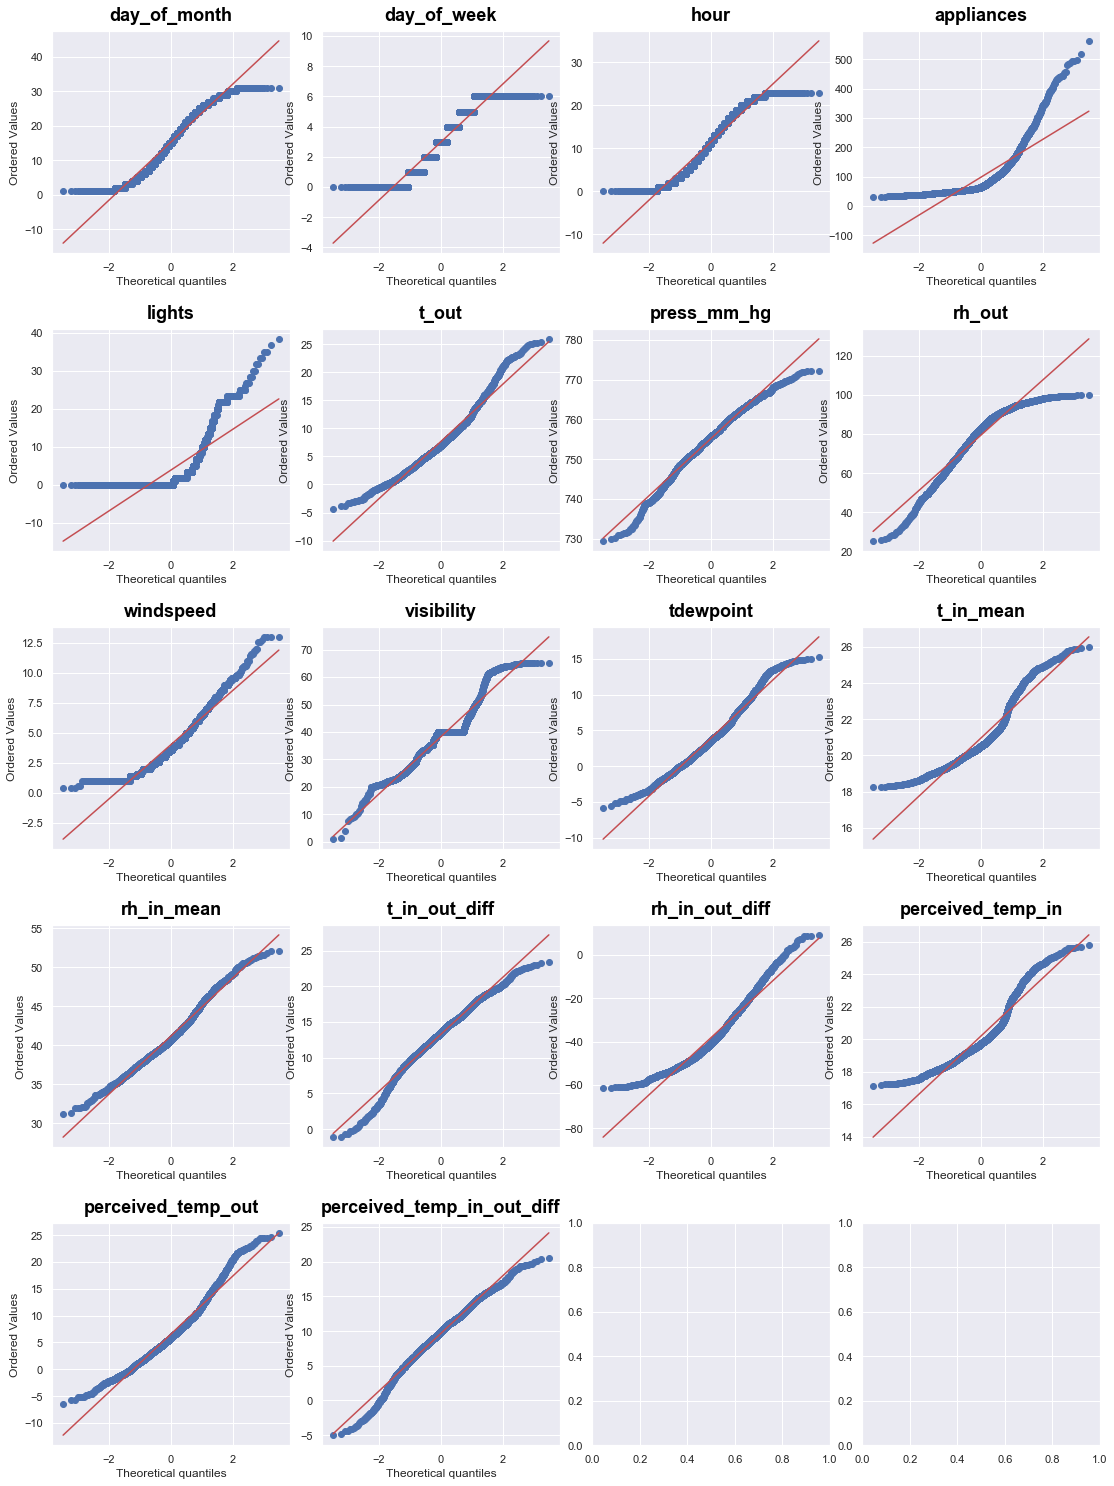

In [25]:
# Normal QQ plot of features and target variable
import scipy.stats as stats
import math

fig_size = 5
graph_cols = 4

fig, ax = plt.subplots(nrows = math.ceil(len(energy_df.columns) / graph_cols), ncols = graph_cols, figsize = (fig_size + 10, fig_size * graph_cols))
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 5)

ax_1 = 0
ax_2 = 0

for index, feature in enumerate(energy_df.columns):
    if(index > 1 and index % graph_cols == 0):
        ax_1 += 1
    ax_2 = (index % graph_cols)
    
    # Plot a normal QQ plot
    stats.probplot(energy_df_lin[feature], plot = ax[ax_1, ax_2])
    
    # Set graph title
    ax[ax_1, ax_2].set_title(label = feature, loc = "center", fontdict = plot_main_title_font, pad = 10)
    
# Hide unwanted text output
pass;

We identify some features that deviate heaviliy from normality, namely **appliances**, **lights**, **rh_5**, **rh_out**, **rh_in_out_diff**, **windspeed**. We are interested in the normality assumptions of the target variable **appliances**, hence we shall attempt to log-tranform its values and see what happens with a second iteration of a normal QQ plot:

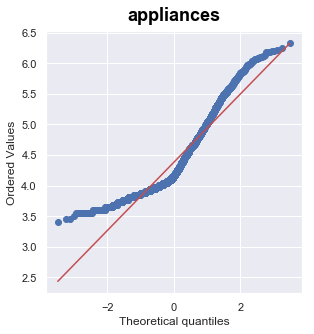

In [26]:
energy_df_log = pd.DataFrame()

# Log transformation
energy_df_log["appliances"] = np.log(energy_df_lin["appliances"])

# Normal QQ plot of features and target variable
import scipy.stats as stats
import math

fig_size = 10
graph_cols = 3

fig, ax = plt.subplots(figsize = (4, 4))
plt.tight_layout(pad = 0, w_pad = 0, h_pad = 5)

    
# Plot a normal QQ plot
stats.probplot(energy_df_log["appliances"], plot = ax)

# Set graph title
ax.set_title(label = "appliances", loc = "center", fontdict = plot_main_title_font, pad = 10)
    
# Hide unwanted text output
pass;

As log-transforming **appliances** brings the values closer to normality, we will proceed with the transformation:

In [27]:
LOG_TRANSFORM_Y = True

energy_df_lin["appliances"] = np.log(energy_df_lin["appliances"])

Let's normalize our data set:

In [28]:
from sklearn import preprocessing

y_column = [
    "appliances"
]

one_hot_columns = [
    "day_of_month",
    "day_of_week",
    "hour",
    #"activity_level"
]


# Temp slice of the df's features that will be one-hot encoded at a later step
energy_df_lin_one_hot = energy_df_lin[one_hot_columns].copy(deep = True)

# Temp slice of the df to be scaled, excluding one-hot columns
energy_df_lin_X = energy_df_lin[energy_df_lin.columns.difference(y_column + one_hot_columns)].copy(deep = True)

# Temp slice of the df's target
energy_df_lin_y = energy_df_lin[y_column].copy(deep = True)

# Keep a reference to the original dataframe index and columns 
# so as to be able to restore them after fiting the scaler
energy_df_lin_index = energy_df_lin.index
energy_df_lin_columns = energy_df_lin.columns

if STANDARD_SCALE:
    scaler_lin_X = preprocessing.StandardScaler().fit(energy_df_lin_X)
    scaler_lin_y = preprocessing.StandardScaler().fit(energy_df_lin_y)
    
    print("Used StandardScaler for energy_df_lin")
else:
    scaler_lin_X = preprocessing.MinMaxScaler().fit(energy_df_lin_X)
    scaler_lin_y = preprocessing.MinMaxScaler().fit(energy_df_lin_y)
    
    print("Used MinMaxScaler for energy_df_lin")
    
energy_df_lin_norm_X = pd.DataFrame(scaler_lin_X.transform(energy_df_lin_X))
energy_df_lin_norm_y = pd.DataFrame(scaler_lin_y.transform(energy_df_lin_y))

# Concatenate the slices to get our original dataset features
# Warning: order is important!
energy_df_lin = pd.concat([energy_df_lin_one_hot, energy_df_lin_norm_y, energy_df_lin_norm_X], axis = 1)

# Set the index to the original dataframe index
energy_df_lin.index = energy_df_lin_index

# Set the columns names to the original dataframe index
energy_df_lin.columns = energy_df_lin_columns

Used MinMaxScaler for energy_df_lin


### One-hot encoding

We shall one-hot encode the ordinal features **day_of_month**, **day_of_week** and **activity_level** in the algebraic models dataset (**energy_df_lin**):

In [29]:
if "day_of_month" in energy_df_lin.columns:
    energy_df_lin = pd.concat([energy_df_lin, pd.get_dummies(energy_df_lin["day_of_month"], prefix = "day_of_month")], axis = 1)
    energy_df_lin = energy_df_lin.drop("day_of_month", axis = 1)
    
if "day_of_week" in energy_df_lin.columns:
    energy_df_lin = pd.concat([energy_df_lin, pd.get_dummies(energy_df_lin["day_of_week"], prefix = "day_of_week")], axis = 1)
    energy_df_lin = energy_df_lin.drop("day_of_week", axis = 1)

if "hour" in energy_df_lin.columns:
    energy_df_lin = pd.concat([energy_df_lin, pd.get_dummies(energy_df_lin["hour"], prefix = "hour")], axis = 1)
    energy_df_lin = energy_df_lin.drop("hour", axis = 1)

## Train 3 different models on the data

### A note on train-test splitting

We will be using a ratio of 80/20 between the train and test sets.

We will define our target variable globally:

In [30]:
y = "appliances"

### A simple linear regression - based model

#### Feature selection and train-test split

In [31]:
# Candidate features list
# All features except those one-hot encoded
lin_model_candidate_features = [
    c for c in energy_df_lin.columns \
    if c.lower() != "appliances" \
    and c.lower()[:13] != "day_of_month_" \
    and c.lower()[:12] != "day_of_week_"  \
    and c.lower()[:5] != "hour_" 
]

# Top-K features
# After experimentation, 5 seems to be the optimal feature length
lin_model_top_k_features_num = 5

#X_train_lin_model, X_test_lin_model, y_train_lin_model, y_test_lin_model = time_series_train_test_split(energy_df_lin, lin_model_candidate_features, y, 5, 4)
X_train_lin_model, X_test_lin_model, y_train_lin_model, y_test_lin_model = train_test_split(energy_df_lin, lin_model_candidate_features, y)

print("\n")
print("Linear model train-test set info")
print("--------------------------------------------------")
print("Training set length: ", len(X_train_lin_model))
print("Test set length: ", len(X_test_lin_model))
print("Ratio: ", round(len(X_test_lin_model) / len(X_train_lin_model), 2))
print("\n")

# K-best features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

select_k_best_model = SelectKBest(f_regression, k = lin_model_top_k_features_num)
select_k_best_model_fit = select_k_best_model.fit_transform(X_train_lin_model, y_train_lin_model)

# Fins the features the model identified as important
select_k_best_model_support = select_k_best_model.get_support()

# List of selected K features
lin_model_top_k_features = []

for bool, feature in zip(select_k_best_model_support, lin_model_candidate_features):
    if bool:
        lin_model_top_k_features.append(feature)

print("\n")
print("Selected top", lin_model_top_k_features_num, "features")
print("----------------------------------------------")
print("%s" % ", " . join(map(str, lin_model_top_k_features)))
print("\n")



Linear model train-test set info
--------------------------------------------------
Training set length:  2261
Test set length:  566
Ratio:  0.25




Selected top 5 features
----------------------------------------------
lights, press_mm_hg, tdewpoint, t_in_mean, t_in_out_diff




In [32]:
X_train_lin_model, X_test_lin_model, y_train_lin_model, y_test_lin_model = train_test_split(energy_df_lin, lin_model_top_k_features, y)

print("\n")
print("Linear model train-test set info")
print("--------------------------------------------------")
print("Training set length: ", len(X_train_lin_model))
print("Test set length: ", len(X_test_lin_model))
print("Ratio: ", round(len(X_test_lin_model) / len(X_train_lin_model), 2))
print("\n")
print("Feature set")
print("--------------------------------------------------")
print("%s" % ", " . join(map(str, lin_model_top_k_features)))
print("\n")



Linear model train-test set info
--------------------------------------------------
Training set length:  2261
Test set length:  566
Ratio:  0.25


Feature set
--------------------------------------------------
lights, press_mm_hg, tdewpoint, t_in_mean, t_in_out_diff




#### Model fitting



Linear model coefficients:  [ 3.79040813e-01 -3.92339771e+12  2.84148363e+11 -1.40625000e-01
  4.15478681e+12]
MAE: 0.14
MSE: 0.03
R2 score: 0.16


0.379 * lights + -3923397709439.912 * press_mm_hg + 284148363137.021 * tdewpoint + -0.141 * t_in_mean + 4154786814864.798 * t_in_out_diff


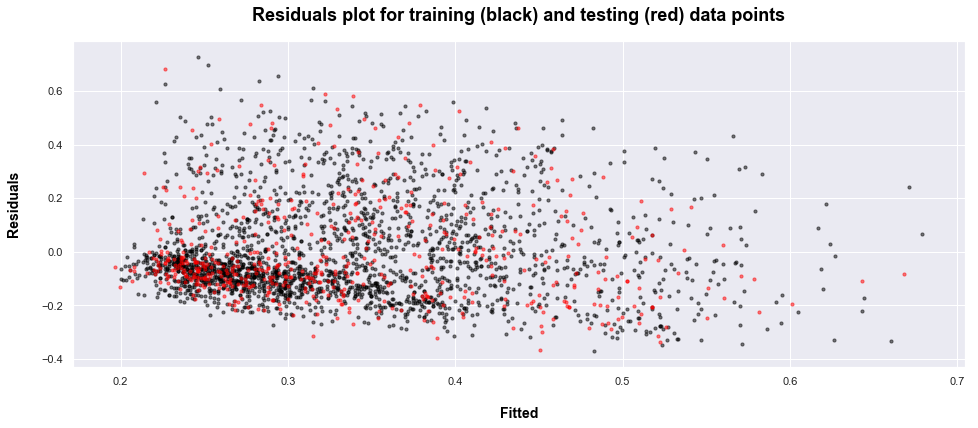

In [33]:
# Linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###
# Model fit
##
lin_model = LinearRegression()

# Fit the model using the training set
lin_model.fit(X_train_lin_model, y_train_lin_model)

# Make predictions using the test set
y_pred_lin_model = lin_model.predict(X_test_lin_model)

###
# Model output
##
print("\n")
# Model coefficients
print("Linear model coefficients: ", lin_model.coef_)
# Model MAE
print("MAE: %.2f" % mean_absolute_error(y_test_lin_model, y_pred_lin_model))
# Model MSE
print("MSE: %.2f" % mean_squared_error(y_test_lin_model, y_pred_lin_model))
# R squared score
print("R2 score: %.2f" % r2_score(y_test_lin_model, y_pred_lin_model));
print("\n")

# Get the model function
print(get_linear_model_function(lin_model.coef_, lin_model_top_k_features))

###
# Visualization
##
fig, ax = plt.subplots(figsize = (16, 6))

# Plot fitted values
ax.scatter(lin_model.predict(X_train_lin_model), y_train_lin_model - lin_model.predict(X_train_lin_model), c = "black", s = 10, alpha = 0.5)

# Plot predicted values from the test set
ax.scatter(lin_model.predict(X_test_lin_model), y_test_lin_model - lin_model.predict(X_test_lin_model), c = "red", s = 10, alpha = 0.5)

# Set graph title
ax.set_title(label = "Residuals plot for training (black) and testing (red) data points", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Fitted", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Residuals", fontdict = plot_axis_title_font, labelpad = 20)

#plt.plot(lin_model.predict(X_train), lin_model.predict(y_train), color='k')

pass;

### A SVM-based regression model (see SVR)

#### Feature selection and train-test split

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features 

Source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Candidate features list
# All features except those one-hot encoded
svr_model_candidate_features = [
    c for c in energy_df_lin.columns \
    if c.lower() != "appliances" \
    and c.lower()[:13] != "day_of_month_" \
    and c.lower()[:12] != "day_of_week_"  \
    and c.lower()[:5] != "hour_" 
]

# Top-K features
svr_model_top_k_features_num = 5

# Recursive feature eliminator
linear_model_estimator = LinearRegression()
recursive_feature_eliminator_model = RFE(linear_model_estimator, n_features_to_select = svr_model_top_k_features_num, step = 1)
recursive_feature_eliminator_model_fit = recursive_feature_eliminator_model.fit_transform(energy_df_lin[svr_model_candidate_features], energy_df_lin[y])
svr_model_top_k_features = np.array(svr_model_candidate_features)[recursive_feature_eliminator_model.support_].tolist()

# Identify K best features
print("\n")
print("Selected top", svr_model_top_k_features_num, "features")
print("----------------------------------------------")
print("%s" % ", " . join(map(str, svr_model_top_k_features)))
print("\n")



Selected top 5 features
----------------------------------------------
press_mm_hg, tdewpoint, rh_in_mean, t_in_out_diff, rh_in_out_diff




In [35]:
X_train_svr_model, X_test_svr_model, y_train_svr_model, y_test_svr_model = train_test_split(energy_df_lin, svr_model_top_k_features, y)

print("\n")
print("SVR model train-test set parameters")
print("--------------------------------------------------")
print("Training set length: ", len(X_train_svr_model))
print("Test set length: ", len(X_test_svr_model))
print("Ratio: ", round(len(X_test_svr_model) / len(X_train_svr_model), 2))
print("\n")
print("Feature set")
print("--------------------------------------------------")
print("%s" % ", " . join(map(str, svr_model_top_k_features)))
print("\n")



SVR model train-test set parameters
--------------------------------------------------
Training set length:  2261
Test set length:  566
Ratio:  0.25


Feature set
--------------------------------------------------
press_mm_hg, tdewpoint, rh_in_mean, t_in_out_diff, rh_in_out_diff




#### Model fitting



Linear model coefficients:  [[ 0.01020578  0.23639701  0.02107516 -0.00652993  0.01066722]]
MAE: 0.15
MSE: 0.03
R2 score: 0.08




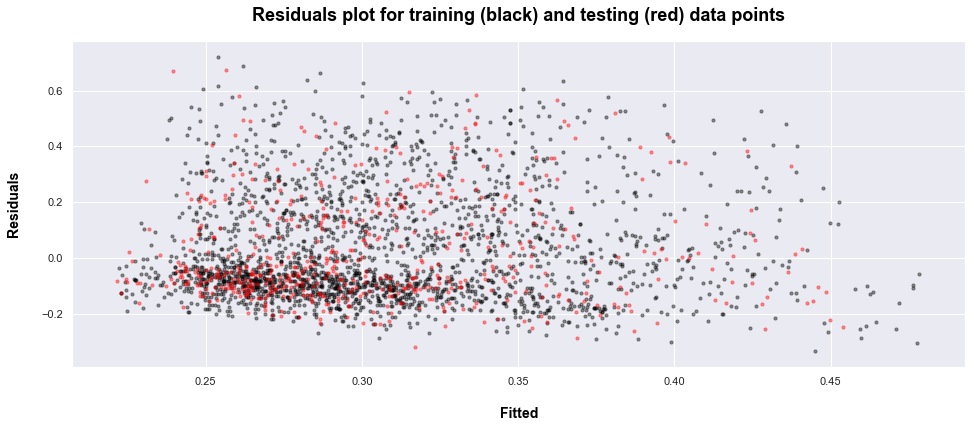

In [36]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###
# Model creation and fit
##
svr_model = SVR(kernel = "linear")
svr_model.fit(X_train_svr_model, y_train_svr_model) 

# Make predictions using the testing set
svr_model_y_pred = svr_model.predict(X_test_svr_model)

print("\n")
# Model coefficients
print("Linear model coefficients: ", svr_model.coef_)
# Model MAE
print("MAE: %.2f" % mean_absolute_error(y_test_svr_model, svr_model_y_pred))
# Model MSE
print("MSE: %.2f" % mean_squared_error(y_test_svr_model, svr_model_y_pred))
# R squared score
print("R2 score: %.2f" % r2_score(y_test_svr_model, svr_model_y_pred));
print("\n")

###
# Visualization
##
fig, ax = plt.subplots(figsize = (16, 6))

# Plot fitted values
ax.scatter(svr_model.predict(X_train_svr_model), y_train_svr_model - svr_model.predict(X_train_svr_model), c = "black", s = 10, alpha = 0.4)

# Plot predicted values from the test set
ax.scatter(svr_model.predict(X_test_svr_model), y_test_svr_model - svr_model.predict(X_test_svr_model), c = "red", s = 10, alpha = 0.4)

# Set graph title
ax.set_title(label = "Residuals plot for training (black) and testing (red) data points", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Fitted", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Residuals", fontdict = plot_axis_title_font, labelpad = 20)

pass;

### A decision trees (random forest) - based model

#### Feature selection and train-test split

We will use the **feature_importances_** variable of a **RandomForestRegressor** model, in order to identify the top 5 features to include in our random forest model:



Random forest regressor model train-test set info
--------------------------------------------------
Training set length:  2261
Test set length:  566
Ratio:  0.25




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


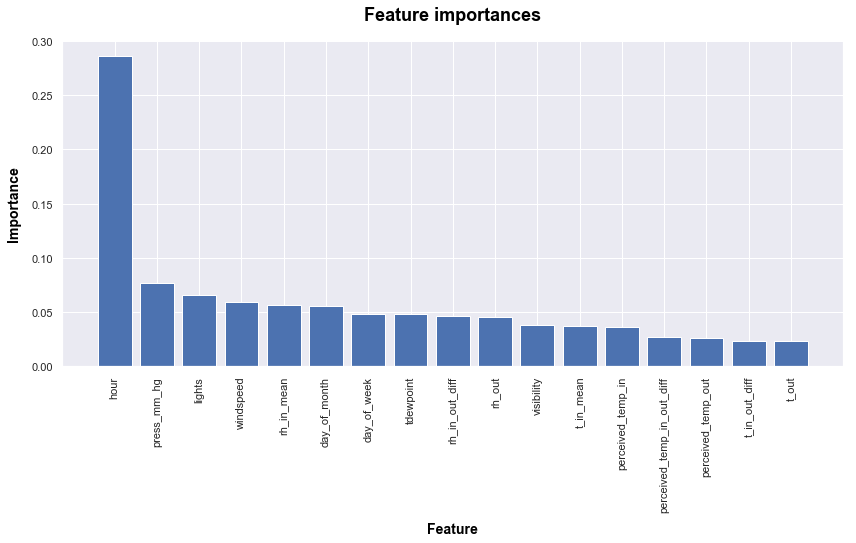

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf_model_candidate_features = lin_model_candidate_features = [
    c for c in energy_df_tree.columns \
    if c.lower() != "appliances"
]

# Create a Random Forest Regressor
random_forest_regressor = RandomForestRegressor(n_estimators = 100, n_jobs = -1, verbose = True)

# Get a train-test split
X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(energy_df_tree, rf_model_candidate_features, y)

print("\n")
print("Random forest regressor model train-test set info")
print("--------------------------------------------------")
print("Training set length: ", len(X_train_rf_model))
print("Test set length: ", len(X_test_rf_model))
print("Ratio: ", round(len(X_test_rf_model) / len(X_train_rf_model), 2))
print("\n")

###
# Model training
##
# Fit the model
random_forest_regressor.fit(X_train_rf_model, y_train_rf_model)
# Get feature importances from the fitted model
feature_importances = random_forest_regressor.feature_importances_
# Sort feature importances descending
feature_importances_indices = np.argsort(feature_importances)[::-1]

###
# Visualization
##
fig, ax = plt.subplots(figsize = (14, 6))

ax.bar(
    range(X_train_rf_model.shape[1]), 
    feature_importances[feature_importances_indices], 
    align = "center",
)

# Set graph title
ax.set_title(label = "Feature importances", loc = "center", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Feature", fontdict = plot_axis_title_font, labelpad = 10)
ax.set_ylabel(ylabel = "Importance", fontdict = plot_axis_title_font, labelpad = 10)

# Set x-axis ticks and corresponding labels to be the index of our series object
ax.set_xticks(np.arange(feature_importances_indices.shape[0]))
ax.set_xticklabels(np.array(energy_df_tree[rf_model_candidate_features].columns)[feature_importances_indices], rotation = 90)

pass;

In [39]:
# Top-K features
# Extensive testing idientified the optimal number of features to be 8
rf_model_top_k_features_num = 8

rf_model_top_k_features = np.array(energy_df_tree[rf_model_candidate_features].columns)[feature_importances_indices][0:rf_model_top_k_features_num].tolist()

X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(energy_df_tree, rf_model_top_k_features, y)

print("\n")
print("Random forest model train-test set parameters")
print("--------------------------------------------------")
print("Training set length: ", len(X_train_rf_model))
print("Test set length: ", len(X_test_rf_model))
print("Ratio: ", round(len(X_test_rf_model) / len(X_train_rf_model), 2))
print("\n")
print("Feature set")
print("--------------------------------------------------")
print("%s" % ", " . join(map(str, rf_model_top_k_features)))
print("\n")



Random forest model train-test set parameters
--------------------------------------------------
Training set length:  2261
Test set length:  566
Ratio:  0.25


Feature set
--------------------------------------------------
hour, press_mm_hg, lights, windspeed, rh_in_mean, day_of_month, day_of_week, tdewpoint




#### Model fitting

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pydotplus
from graphviz import Source
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

from IPython.display import Image

###
# Model creation and fit
##
rf_model = RandomForestRegressor(n_estimators = 100, max_depth = None, n_jobs = -1, random_state = 19730618, verbose = False)
rf_model.fit(X_train_rf_model, y_train_rf_model)

# Make predictions using the testing set
y_pred_rf_model = rf_model.predict(X_test_rf_model)

print("\n")
# Model MAE
print("MAE: %.2f" % mean_absolute_error(y_test_rf_model, y_pred_rf_model))
# Model MSE
print("MSE: %.2f" % mean_squared_error(y_test_rf_model, y_pred_rf_model))
# R squared score
print("R2 score: %.2f" % r2_score(y_test_rf_model, y_pred_rf_model));
print("\n")

if(int(rf_model.estimators_[0].tree_.max_depth) <= 5):
    ###
    # Visualization
    ##
    # Set the GraphViz executable path (Windows)
    os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"

    # Set the GraphViz executable path (Linux)
    #os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

    dot_data = StringIO()
    export_graphviz(rf_model.estimators_[0], out_file = dot_data, feature_names = X_train_rf_model.columns, filled = True, rounded = True, special_characters = True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    Image(graph.create_png())
else:
    print("Tree depth too large to visualize: ", rf_model.estimators_[0].tree_.max_depth)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=19730618, verbose=False,
           warm_start=False)



MAE: 32.06
MSE: 2849.40
R2 score: 0.46


Tree depth too large to visualize:  24


## Model Evaluation & Selection

### Train-test splitting of the data set

A 10-fold cross-validation test setting will be used. This technique holds out an increasing larger sample of the dataset for training and one for testing. Pictorially, the K-fold cross validation strategy is implemented as shown below:

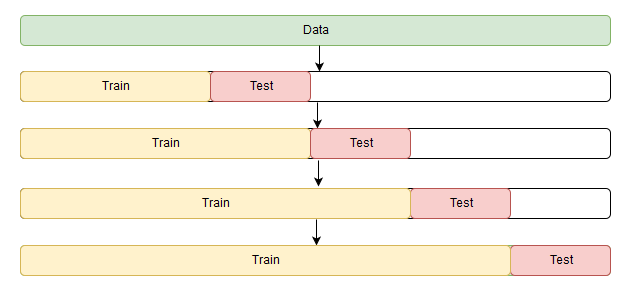

### Choosing an appropriate scoring metric

For regression models, the most common metrics of performance evaluation are the following:

**Mean Absolute Error**: $MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$: it is calculated by taking the mean value of the absolute differences between the predicted ($\hat{y_{i}}$) and true ($y_{i}$) values of $y$.

**Mean Squared Error**: $MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^{2}$: calculated as the average of the squares of the difference between the predicted ($\hat{y_{i}}$) and true ($y_{i}$) values of $y$.

**Root Mean Squared Error**: $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^{2}}$: the square root of MSE, value is in the units of the target variable $y$.

**Coefficient of Determination**: $R^{2} = 1-\frac{SS_{reg}}{SS_{tot}}$: it shows the proportion of variance which is explained by the model. Ranges from 0 to 1 where perfect fit is 1.

We will use **MAE** which is a metric that explains with relative clarity the errors of the regressor. We wish to have as low a value as possible for this, therefore the model with the lowest value will be finally selected.

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Selection of features that will be used for each model
X_lin_model = energy_df_lin[lin_model_top_k_features]
X_svr_model = energy_df_lin[svr_model_top_k_features]
X_rf_model = energy_df_tree[rf_model_top_k_features]

# Define a cross validation shuffle
cv = KFold(n_splits = K_FOLDS, shuffle = False, random_state = 19730618)

In [42]:
# Define a data frame to hold cross-validation scores
metrics_df = pd.DataFrame(index = ["lin_model", "svr_model", "rf_model"], columns = ["MAE", "MSE", "R2"])

# Mean Absolute Error
metrics_df.loc["lin_model", "MAE"] = np.abs(np.round(np.mean(cross_val_score(lin_model, X_lin_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_absolute_error")), 3))
metrics_df.loc["svr_model", "MAE"] = np.abs(np.round(np.mean(cross_val_score(svr_model, X_svr_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_absolute_error")), 3))
metrics_df.loc["rf_model", "MAE"] = np.abs(np.round(np.mean(cross_val_score(rf_model, X_rf_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_absolute_error")), 3))

# Mean Squared Error
metrics_df.loc["lin_model", "MSE"] = np.abs(np.round(np.mean(cross_val_score(lin_model, X_lin_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_squared_error")), 3))
metrics_df.loc["svr_model", "MSE"] = np.abs(np.round(np.mean(cross_val_score(svr_model, X_svr_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_squared_error")), 3))
metrics_df.loc["rf_model", "MSE"] = np.abs(np.round(np.mean(cross_val_score(rf_model, X_rf_model, energy_df_lin[y], cv = cv, scoring = "neg_mean_squared_error")), 3))

# R2 score
metrics_df.loc["lin_model", "R2"] = np.abs(np.round(np.mean(cross_val_score(lin_model, X_lin_model, energy_df_tree[y], cv = cv, scoring = "r2")), 3))
metrics_df.loc["svr_model", "R2"] = np.abs(np.round(np.mean(cross_val_score(svr_model, X_svr_model, energy_df_tree[y], cv = cv, scoring = "r2")), 3))
metrics_df.loc["rf_model", "R2"] = np.abs(np.round(np.mean(cross_val_score(rf_model, X_rf_model, energy_df_tree[y], cv = cv, scoring = "r2")), 3))

metrics_df

,MAE,MSE,R2
lin_model,0.144,0.034,0.088
svr_model,0.153,0.038,0.139
rf_model,0.116,0.025,0.206


In [43]:
print("\n")
print("Final report of test runs")
print("--------------------------------------------------")
print("\n")
print("Parameters")
print("\n")
print("DROP_DETAILED_T_OBSERVATIONS\t", DROP_DETAILED_T_OBSERVATIONS)
print("DROP_DETAILED_RH_OBSERVATIONS\t", DROP_DETAILED_RH_OBSERVATIONS)
print("GROUP\t\t\t\t", GROUP)
print("STANDARD_SCALE\t\t\t", STANDARD_SCALE)
print("LOG_TRANSFORM_Y\t\t\t", LOG_TRANSFORM_Y)
print("K_FOLDS\t\t\t\t", K_FOLDS)
print("\n")
print("lin_model feature set")
print("\n")
print("%s" % ", " . join(map(str, lin_model_top_k_features)))
print("\n")
print("svr_model feature set")
print("\n")
print("%s" % ", " . join(map(str, svr_model_top_k_features)))
print("\n")
print("rf_model feature set")
print("\n")
print("%s" % ", " . join(map(str, rf_model_top_k_features)))
print("\n")
print("Metrics")
print("\n")
print(metrics_df)
print("\n")

# metrics_df.to_clipboard(index = True, header = True)



Final report of test runs
--------------------------------------------------


Parameters


DROP_DETAILED_T_OBSERVATIONS	 True
DROP_DETAILED_RH_OBSERVATIONS	 True
GROUP				 True
STANDARD_SCALE			 False
LOG_TRANSFORM_Y			 True
K_FOLDS				 5


lin_model feature set


lights, press_mm_hg, tdewpoint, t_in_mean, t_in_out_diff


svr_model feature set


press_mm_hg, tdewpoint, rh_in_mean, t_in_out_diff, rh_in_out_diff


rf_model feature set


hour, press_mm_hg, lights, windspeed, rh_in_mean, day_of_month, day_of_week, tdewpoint


Metrics


             MAE    MSE     R2
lin_model  0.144  0.034  0.088
svr_model  0.153  0.038  0.139
rf_model   0.116  0.025  0.206




**Conclusion**: based on the **MAE**, we will choose the RF model for GridSearchCV optimization.

## Parameter Tuning with GridSearchCV

In [44]:
# Random forest model grid search
from sklearn.model_selection import GridSearchCV

# Select the features
X = energy_df_tree[rf_model_top_k_features]
    
# Select the response variable
y = energy_df_tree["appliances"]

rf_model_params_grid = {
    "n_estimators": [500],
    # Important
    "max_depth": [None] + [int(x) for x in np.arange(start = 5, stop = 34, step = 10)],
    "criterion": ["mae", "mse"],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

print("\n")
print("Running GridSearcCV with the following parameters\n\n")
pprint(rf_model_params_grid)
print("\n")

# Parameters random search with K-fold 
# Setting refit = True will provide us with a final trained model
rf_model_grid_search_cv = GridSearchCV(estimator = rf_model, param_grid = rf_model_params_grid, cv = K_FOLDS, refit = True, verbose = 3, n_jobs = -1)

# Fit the random forest model
rf_model_grid_search_cv.fit(X, y)



Running GridSearcCV with the following parameters


{'bootstrap': [True, False],
 'criterion': ['mae', 'mse'],
 'max_depth': [None, 5, 15, 25],
 'max_features': ['sqrt', 'log2'],
 'n_estimators': [500]}


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  8.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=19730618, verbose=False,
           warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [500], 'max_depth': [None, 5, 15, 25], 'criterion': ['mae', 'mse'], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [45]:
rf_model_grid_search_cv.best_params_
rf_model_grid_search_cv.best_estimator_
rf_model_grid_search_cv.best_score_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'log2',
 'n_estimators': 500}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=19730618, verbose=False,
           warm_start=False)

0.2363498917433975

We obtain the best-parameter refitted RandomForestRegression model thus:

In [46]:
best_model = rf_model_grid_search_cv.best_estimator_

In [47]:
best_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=19730618, verbose=False,
           warm_start=False)

# Appendix: Homework 3

Save the best model so as to be used in Homework 3.

For this, we will need to create a pipeline object which will include the following estimators:

- The scaler that was used to normalize the data: we will employ the inverse_transform() method of the scaler to retrieve the original target variable value
- The model that was chosen as best from our previous work

In [48]:
# Using a pipeline to save the scaler, encoder, model
# prepare the pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.externals import joblib

frozen_model_filename = "../003/load_forecasting_model_v010.joblib"
joblib.dump(best_model, frozen_model_filename)

['../003/load_forecasting_model_v010.joblib']

A test case:

In [49]:
energy_df[[
    "appliances",
    "hour", 
    "press_mm_hg", 
    "lights", 
    "windspeed", 
    "rh_in_mean", 
    "day_of_month", 
    "tdewpoint", 
    "day_of_week"
]].head(1)

,appliances,hour,press_mm_hg,lights,windspeed,rh_in_mean,day_of_month,tdewpoint,day_of_week
0,45.0,0,755.833333,13.333333,8.416667,49.983941,1,10.291667,0


---